# 0.1 Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# 0.2 Importing modules

In [3]:
from config import Config
from preprocess import create_image_dataframe, create_gen, plot_category_distribution, display_images
from models import create_model
from evaluation import (accuracy_score, display_confusion_matrix, save_classification_report)

# 1. Data Loading and Preprocessing:

In [4]:
# Create a list with the filepaths for training and testing
dir_ = Path(Config.train_data_path)
train_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path(Config.test_data_path)
test_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path(Config.val_data_path)
val_file_paths = list(dir_.glob(r'**/*.jpeg'))

In [5]:
# Creating data fames of train and test with images and path files address for visualization

train_df = create_image_dataframe(train_file_paths)
val_df = create_image_dataframe(val_file_paths)

# Combine train_df and val_df
train_df = pd.concat([train_df,val_df]).reset_index(drop = True)
test_df = create_image_dataframe(test_file_paths)


print(f'Number of pictures in the training set: {train_df.shape[0]}')
print(f'Number of pictures in the test set: {test_df.shape[0]}')
print(f'Number of pictures in the validation set: {val_df.shape[0]}\n')


print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training set: 5232
Number of pictures in the test set: 624
Number of pictures in the validation set: 16

Number of different labels: 2

Labels: ['PNEUMONIA' 'NORMAL']


Filepath      Label
0  data\train\PNEUMONIA\person1288_virus_2211.jpeg  PNEUMONIA
1      data\train\NORMAL\NORMAL2-IM-0816-0001.jpeg     NORMAL
2  data\train\PNEUMONIA\person61_bacteria_290.jpeg  PNEUMONIA
3   data\train\PNEUMONIA\person722_virus_1341.jpeg  PNEUMONIA
4  data\train\PNEUMONIA\person1141_virus_1890.jpeg  PNEUMONIA

C:\Users\mahdis\Documents\Pnemunia\preprocess.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted(vc.index), y=vc, palette="Set2")


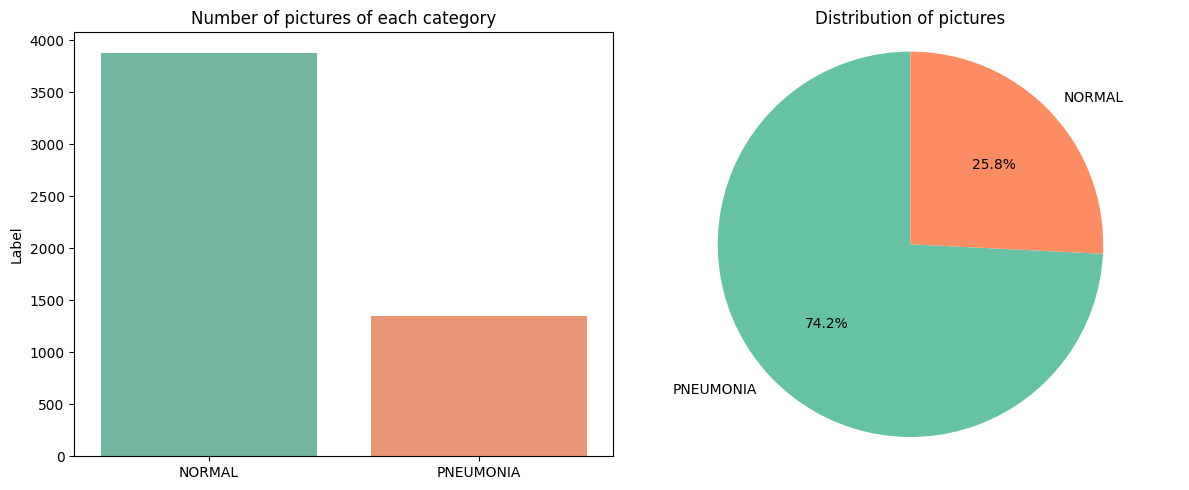

In [6]:
# Plotting category distribution of train
plot_category_distribution(train_df, './')

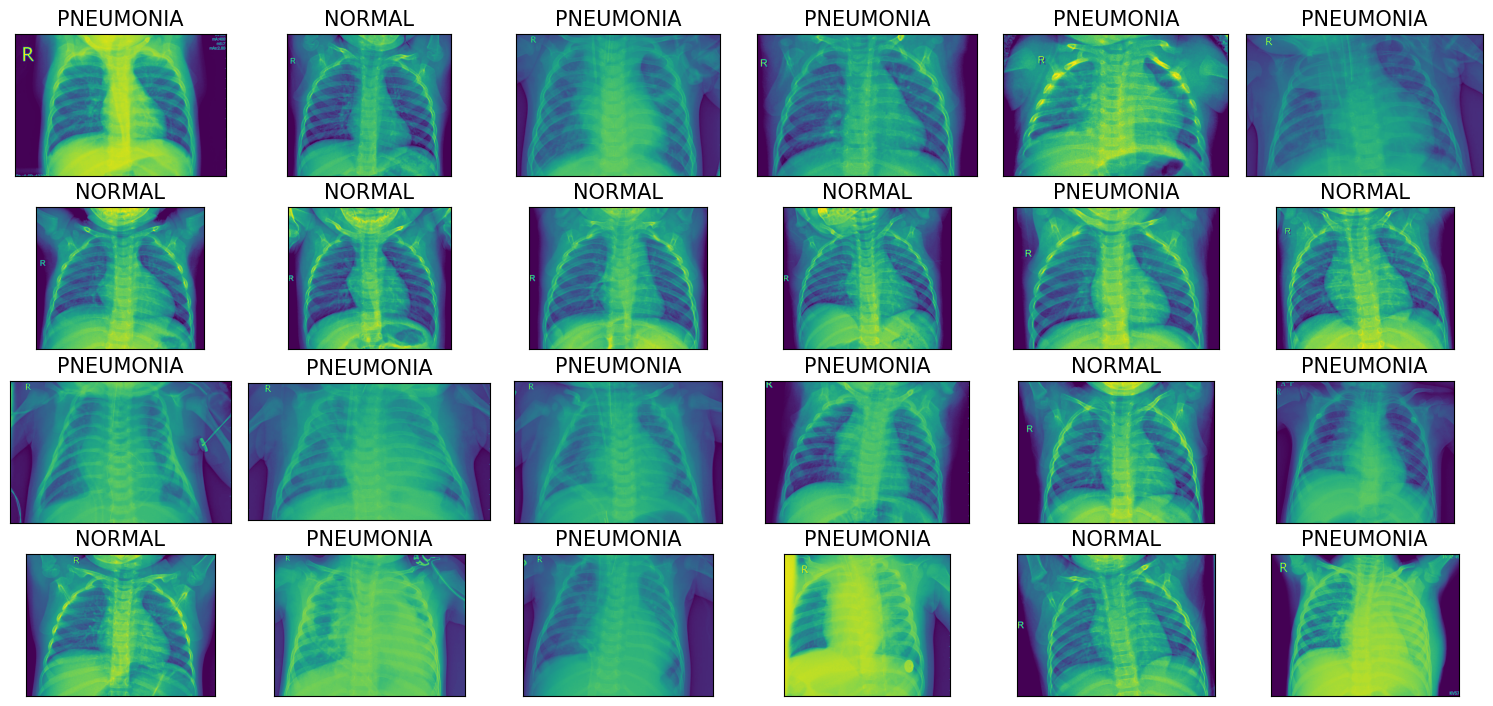

In [7]:
# Displaying images in training set
display_images(train_df, nrows=4, ncols=6, figsize=(15, 7), save_path='./')

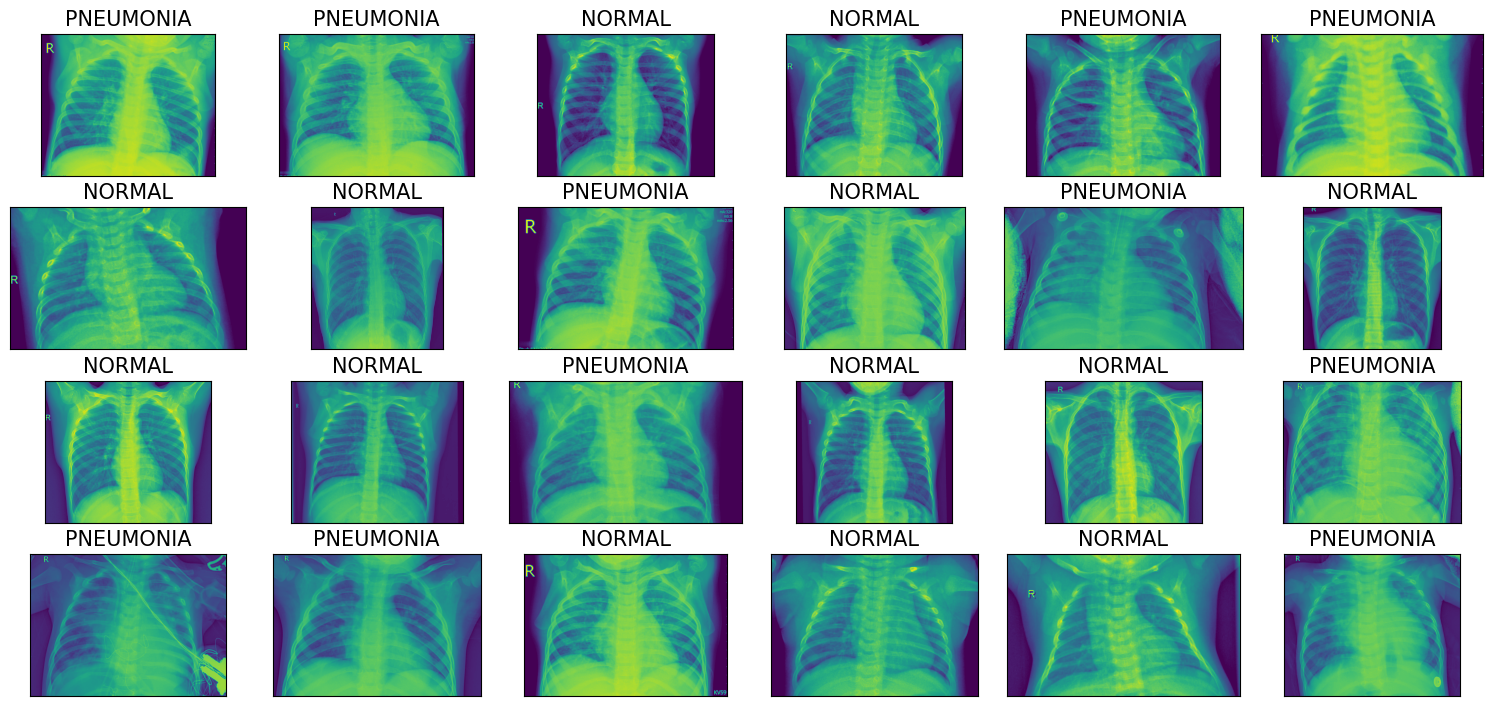

In [8]:
# Displaying images in val set
display_images(test_df, nrows=4, ncols=6, figsize=(15, 7), save_path='./')

# 1.2 Load the Images with data generator + Augmentation

In [9]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# 2. Training

In [12]:
# Fit the models
for name, model in models.items():
    
    # Get the model
    model_ = create_model(model['model'])
    models[name]['model'] = model_
    
    start = perf_counter()
    
    # Fit the model
    history = model_.fit(train_images, validation_data = val_images, epochs = Config.epochs, verbose = 0)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(val,4) for val in val_acc]

Found 4709 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


DenseNet121          trained in 121.13 sec
MobileNetV2          trained in 115.8 sec


2023-09-24 21:19:13.587965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB7       trained in 131.19 sec
InceptionResNetV2    trained in 129.06 sec
InceptionV3          trained in 117.81 sec
MobileNetV3Large     trained in 115.23 sec
171446536/171446536 [==============================] - 8s 0us/step
ResNet101            trained in 122.78 sec
94765736/94765736 [==============================] - 5s 0us/step
ResNet50             trained in 116.44 sec
80134624/80134624 [==============================] - 4s 0us/step
VGG19                trained in 118.03 sec
83683744/83683744 [==============================] - 4s 0us/step
Xception             trained in 119.05 sec


# 3. Prediction

In [13]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

20/20 [==============================] - 6s 282ms/step


In [22]:
# Create a DataFrame with the results
models_result = []

for name, val in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy (test set)','Training time (sec)'])
df_results.sort_values(by='accuracy (test set)', ascending=False, inplace=True)
df_results.reset_index(inplace=True, drop=True)

# Save df_results to a text file
df_results.to_csv(Config.model_dir, index=False, sep='\t')
df_results

model  val_accuracy  accuracy (test set)  Training time (sec)
0           ResNet50        0.9618               0.8910               116.44
1     EfficientNetB7        0.9560               0.8638               131.19
2           Xception        0.8853               0.8093               119.05
3        InceptionV3        0.8356               0.8029               117.81
4   MobileNetV3Large        0.9598               0.7965               115.23
5          ResNet101        0.9331               0.7869               122.78
6  InceptionResNetV2        0.7782               0.7788               129.06
7        MobileNetV2        0.9216               0.7372               115.80
8        DenseNet121        0.8413               0.6394               121.13
9              VGG19        0.7323               0.6250               118.03

# 4. Visualizaing Results

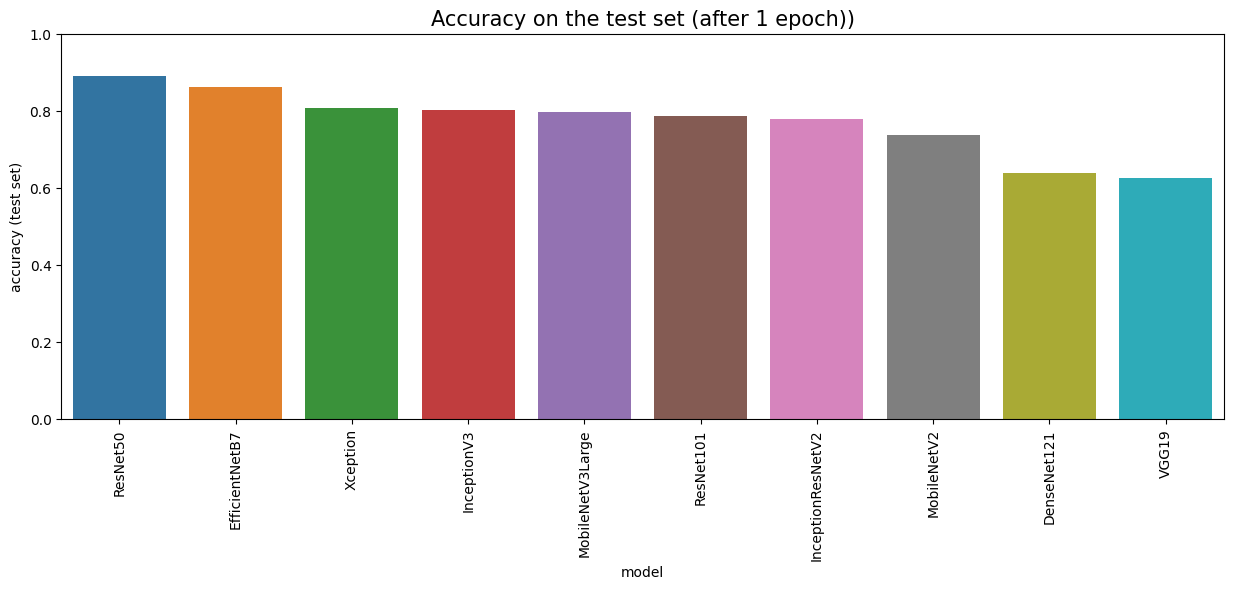

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy (test set)', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

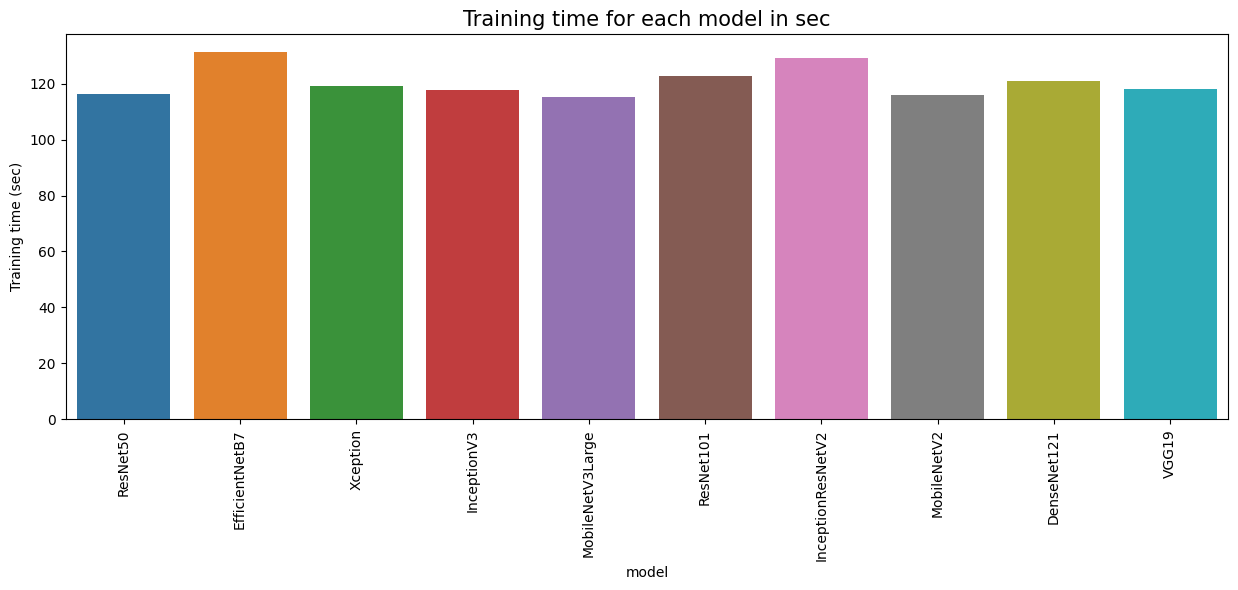

In [16]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 5. Model Selection

In [17]:
acc = df_results.iloc[0]['accuracy (test set)']
best_model = df_results.iloc[0]['model']
print(f'Best model: {best_model}')
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Best model: ResNet50
Accuracy on the test set: 89.10%


In [18]:
# Save the best model
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model.h5')
models[best_model]['model'].save(Config.model_dir)
print(f'Best model saved at: {Config.model_dir}')

Best model saved at: saved_models/best_model.h5


In [23]:
# Predict the labels of the test_images for the best model
pred = models[best_model]['model'].predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
models[name]['acc'] = round(acc,4)

20/20 [==============================] - 5s 255ms/step


Confusion matrix saved as /kaggle/working/confusion_matrix.png


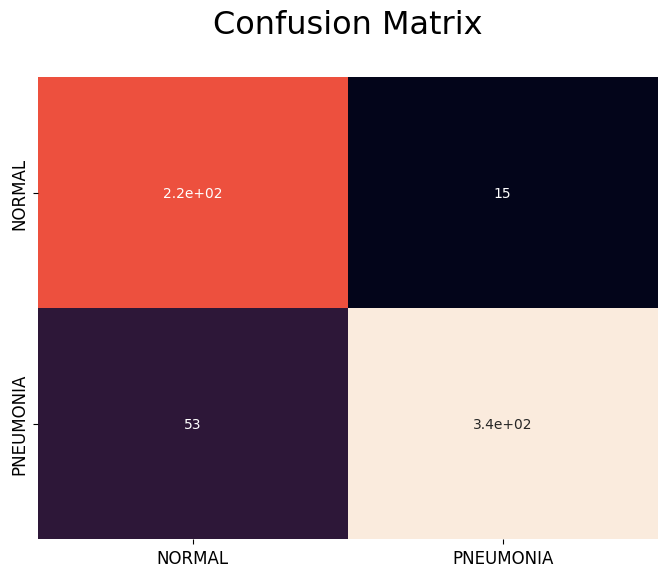

In [24]:
# displaying confusion matrix
display_confusion_matrix(y_test, pred, Config.confusion_matrix_save_path)

In [25]:
# saving report
save_classification_report(y_test, pred, Config.classification_report_path)

              precision    recall  f1-score   support

      NORMAL       0.81      0.94      0.87       234
   PNEUMONIA       0.96      0.86      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.89       624

Classification report saved as /kaggle/working/classification_report.txt


## 5. Examples of prediction


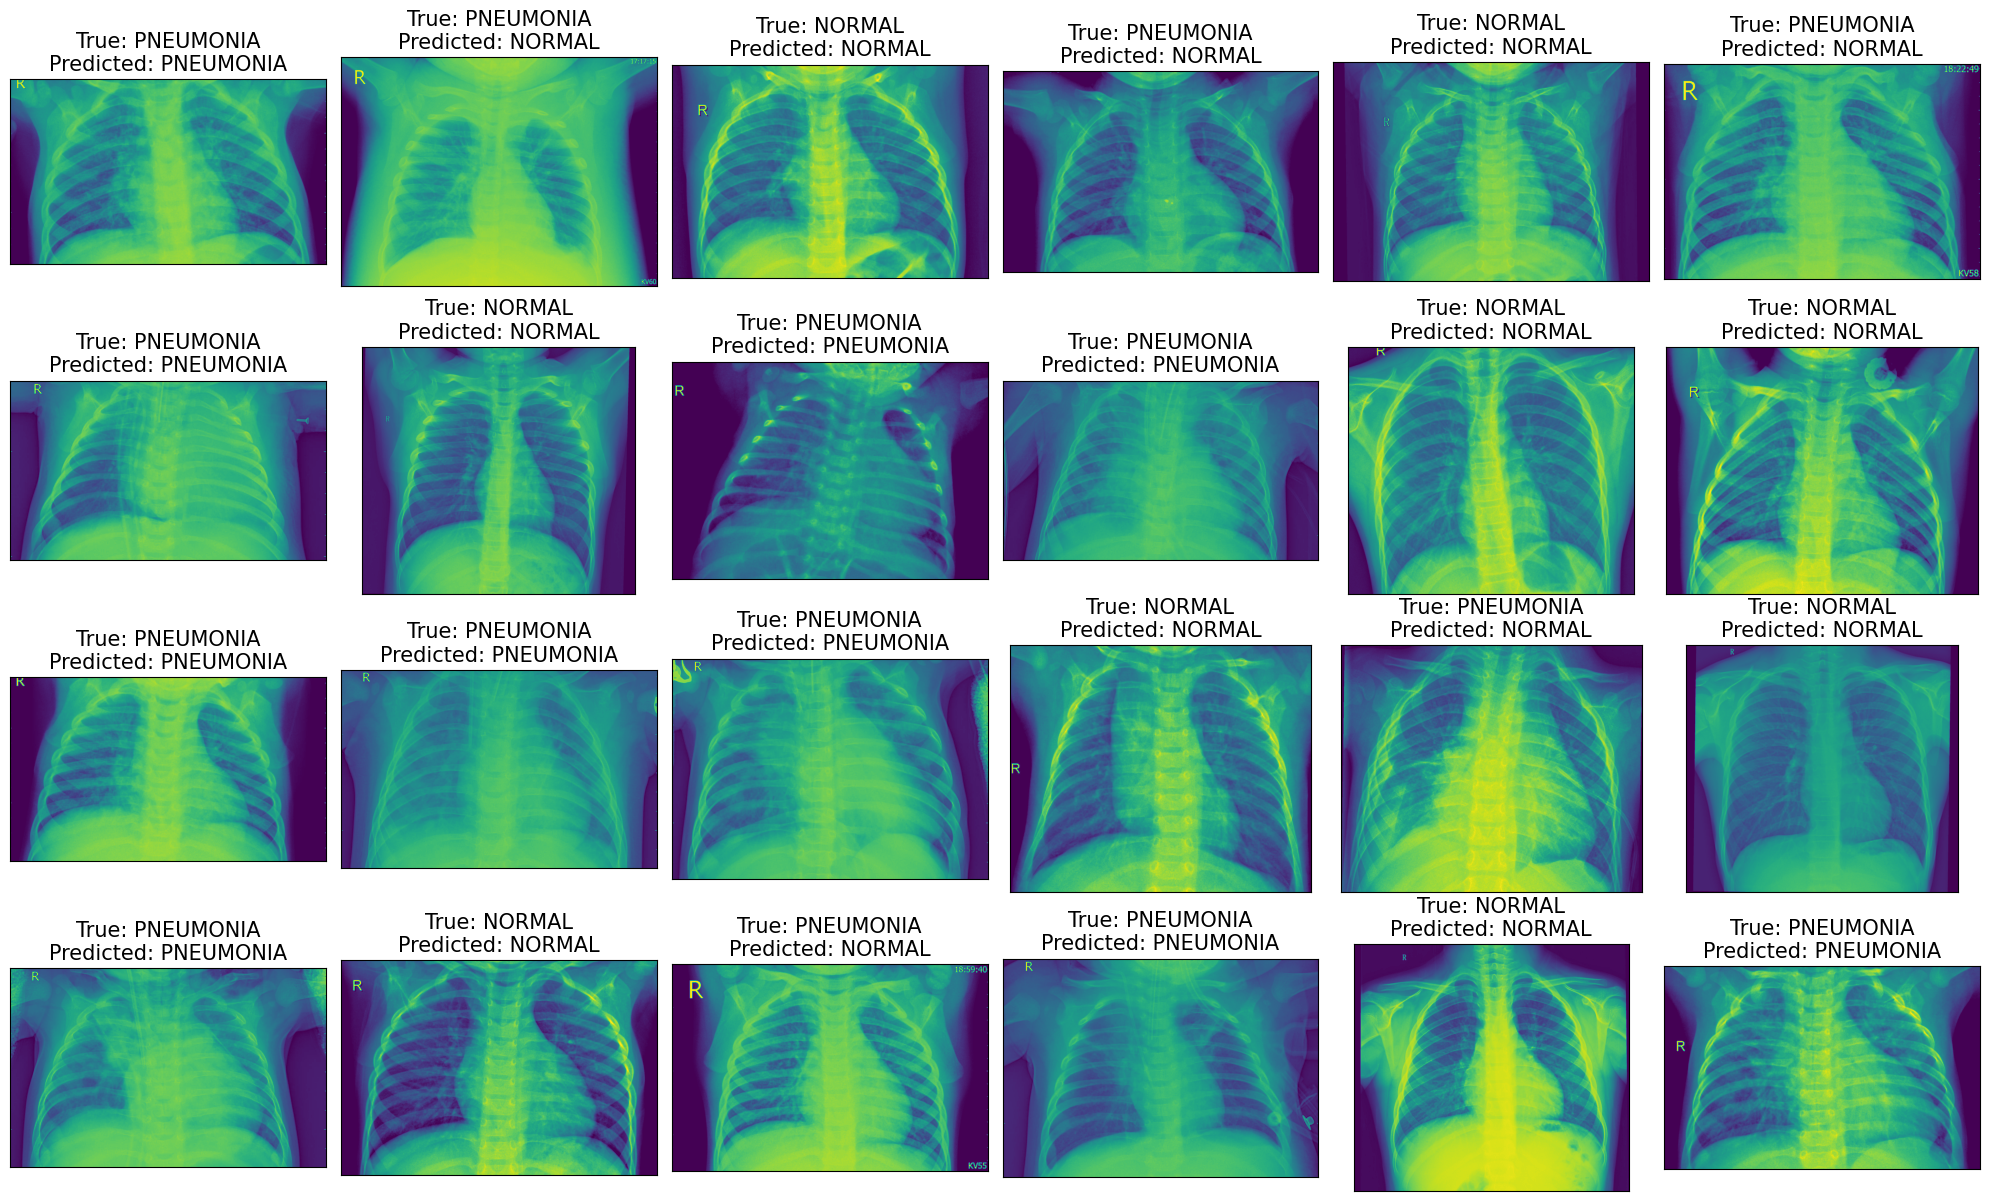

In [26]:
# displaying results
    
display_predicted_images(test_df, pred)